In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install lightfm

In [ ]:
import pandas as pd
from lightfm import LightFM, data
import numpy as np
from sklearn.decomposition import PCA

from scipy.sparse import coo_matrix, csr_matrix, identity, hstack
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [ ]:
def is_convrtable_to_int(row: str):
    try:
        int(row)
    except ValueError:
        return False
    return True

is_convrtable_to_int_v = np.vectorize(is_convrtable_to_int)

In [ ]:
metadata_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/movies_metadata.csv.zip', compression='zip')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
metadata_frame.head()

In [ ]:
metadata_frame = metadata_frame[is_convrtable_to_int_v(metadata_frame.id)].astype({'id': 'int64'}).sort_values('id')

In [ ]:
overview_frame = metadata_frame[['id', 'overview', 'genres']].dropna()

In [ ]:
overview_frame.shape

(44509, 3)

In [ ]:
import ast

def add_genres(row):
    genres = ast.literal_eval(row['genres'])
    genres_str = ' '
    for genre in genres:
        genres_str += genre['name'] + '. '
    row['overview'] += genres_str
    return row

pd.options.display.max_colwidth = 1000
overview_frame = overview_frame.apply(add_genres, axis=1) \
                 .drop('genres', axis=1) \
                 .set_index('id')

In [ ]:
keywords_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/keywords.csv.zip', compression='zip')

In [ ]:
keywords_frame.drop_duplicates(subset='id', inplace=True)
keywords_frame = keywords_frame.set_index('id')

In [ ]:
keywords_frame.head()

In [ ]:
keywords_frame.shape

(45432, 1)

In [ ]:
overview_frame = overview_frame.join(keywords_frame, on='id', how='inner')

In [ ]:
overview_frame.shape

(44508, 2)

In [ ]:
overview_frame.head(1)

,overview,keywords
id,,
2,"Taisto Kasurinen is a Finnish coal miner whose father has just committed suicide and who is framed for a crime he did not commit. In jail, he starts to dream about leaving the country and starting a new life. He escapes from prison but things don't go as planned... Drama. Crime.","[{'id': 240, 'name': 'underdog'}, {'id': 378, 'name': 'prison'}, {'id': 730, 'name': 'factory worker'}, {'id': 1563, 'name': 'prisoner'}, {'id': 1787, 'name': 'helsinki'}, {'id': 10183, 'name': 'independent film'}, {'id': 13072, 'name': 'falling in love'}]"


In [ ]:
import ast

def add_keywords(row):
    genres = ast.literal_eval(row['keywords'])
    genres_str = ' '
    for genre in genres:
        genres_str += genre['name'] + '. '
    row['overview'] += genres_str
    return row

overview_frame = overview_frame.apply(add_keywords, axis=1) \
                 .drop('keywords', axis=1)

overview_frame.shape

(44508, 1)

In [ ]:
# overview_frame = overview_frame[overview_frame.id < 50_000]

In [ ]:
movies_with_descriprions_ids = np.array(overview_frame.reset_index().id)
movies_with_descriprions_ids

array([     2,      3,      5, ..., 467731, 468343, 469172])

In [ ]:
np.savetxt('/content/drive/My Drive/Colab Notebooks/Course Work/movies_with_descriprions_ids.csv', 
           movies_with_descriprions_ids, delimiter=',')

In [ ]:
movies_with_descriprions_ids.shape

(44508,)

In [ ]:
overview_frame.to_csv('/content/drive/My Drive/Colab Notebooks/Course Work/overview.csv.zip', compression='zip')

In [ ]:
overview_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/overview.csv.zip', compression='zip')

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder-large/5")

In [ ]:
n_rows = 1000

overview_embeddings = np.empty(shape=(0, 512))

for chunk in np.array_split(overview_frame['overview'], overview_frame.shape[0] // n_rows):
    overview_embeddings = np.append(overview_embeddings, embed(chunk).numpy(), axis=0)

In [ ]:
np.savetxt('/content/drive/My Drive/Colab Notebooks/Course Work/overview_embeddings.csv', overview_embeddings, delimiter=',')

In [ ]:
overview_embeddings = np.loadtxt('/content/drive/My Drive/Colab Notebooks/Course Work/overview_embeddings.csv', delimiter=',')
movies_with_descriprions_ids = np.loadtxt('/content/drive/My Drive/Colab Notebooks/Course Work/movies_with_descriprions_ids.csv', 
                                          delimiter=',',
                                          dtype=np.int32)

In [ ]:
overview_embeddings.shape

(44508, 512)

In [ ]:
overview_embeddings

array([[-0.03499091, -0.0422627 , -0.03124978, ...,  0.03598393,
         0.01167009,  0.00257467],
       [-0.03679639,  0.01993529,  0.07856163, ...,  0.06258022,
         0.01493586, -0.03303393],
       [-0.02529175,  0.09506747, -0.00644667, ...,  0.06472382,
         0.04709551, -0.01815612],
       ...,
       [ 0.02165906,  0.02666583, -0.05355579, ..., -0.00745962,
        -0.07921766, -0.01739031],
       [-0.06335865, -0.06757613, -0.07449392, ...,  0.02831239,
        -0.02224197, -0.00719173],
       [ 0.09949602, -0.0485029 ,  0.00316402, ...,  0.04827382,
        -0.05501109,  0.01770949]])

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

film_range = range(591)
X_embedded = TSNE(n_components=2).fit_transform(overview_embeddings[film_range])
X_embedded.shape

(591, 2)

In [ ]:
ids = movies_with_descriprions_ids[film_range]
movies_claster_df = metadata_frame[metadata_frame['id'].isin(ids)][['original_title']]
movies_claster_df['x'] = X_embedded[:, 0]
movies_claster_df['y'] = X_embedded[:, 1]
movies_claster_df

In [ ]:
import plotly.express as px
from pylab import rcParams
rcParams['figure.figsize'] = 10,5

fig = px.scatter(movies_claster_df, x='x', y='y', text='original_title', width=1500, height=800)

fig.show()
fig.write_html('/content/drive/My Drive/Colab Notebooks/Course Work/hp_graph.html')

##LightFm

In [ ]:
rating_frame = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Course Work/ratings.csv.zip', compression='zip')

In [ ]:
rating_frame.head()

,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556


In [ ]:
rating_frame.shape

(26024289, 4)

In [ ]:
rating_frame_cut = rating_frame[rating_frame.movieId.isin(movies_with_descriprions_ids)].drop('timestamp', axis=1)

In [ ]:
def encode_binary(x):
    return 1 if x >= 4 else -1

rating_frame_cut['rating'] = rating_frame_cut['rating'].apply(encode_binary)

In [ ]:
rating_frame_cut.head()

,userId,movieId,rating
0,1,110,-1
1,1,147,1
2,1,858,1
4,1,1246,1
5,1,1968,1


In [ ]:
rating_frame_cut.shape

(11395911, 3)

### Build frame

In [ ]:
# rating_frame_cut = rating_frame_cut[rating_frame_cut.userId < 150_000]

In [ ]:
users_count = max(rating_frame_cut['userId']) + 1
movies_count = max(rating_frame_cut['movieId']) + 1
users_count, movies_count

In [ ]:
rating_frame_cut.shape

(11395911, 3)

In [ ]:
from sklearn.decomposition import PCA

def build_item_csr_matrix(overview_embeddings, 
                          ids, 
                          movies_count, 
                          n_comp=10, 
                          use_pca=True,
                          use_indicator=True):

    if use_pca:
        pca = PCA(n_components=n_comp)
        overview_embeddings = pca.fit_transform(overview_embeddings)
    else:
        overview_embeddings = overview_embeddings[:, :n_comp]
    overview_embeddings_df = pd.DataFrame(
        data=overview_embeddings[:ids.shape[0]], 
        columns=['overview_' + str(i) for i in range(overview_embeddings.shape[1])])
    
    overview_embeddings_df.insert(0, 'id', ids) 
    overview_embeddings_df = overview_embeddings_df \
        .drop_duplicates(subset='id') \
        .set_index('id')


    index_df = pd.DataFrame()
    index_df['id'] = range(movies_count)
    overview_embeddings_df = overview_embeddings_df \
        .join(index_df, how='right') \
        .drop('id', axis=1).fillna(0)

    return hstack([identity(overview_embeddings_df.shape[0], format='csr'), 
                  csr_matrix(overview_embeddings_df.values)]) if use_indicator \
                  else csr_matrix(overview_embeddings_df.values)
    

### CV

In [ ]:
movies_features_sparsed = build_item_csr_matrix(overview_embeddings, movies_with_descriprions_ids, movies_count)

In [ ]:
movies_features_sparsed

In [ ]:
from sklearn.model_selection import KFold


def roc_auc(y_true, y_pred):
    labels = [0 if i < 0 else 1 for i in y_true]
    return roc_auc_score(labels, y_pred)

roc_auc_scorer = make_scorer(
    roc_auc
)


def cross_val(df, param_grid, n_splits=3,
              user_features=None, 
              item_features=None):

    roc_auc_scores = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=125)
    for train, test in kf.split(df):
        train_frame = df.iloc[train]
        test_frame = df.iloc[test]

        y_true = test_frame['rating']

        rating_frame_sparse = coo_matrix((train_frame['rating'], 
                                          (train_frame['userId'], 
                                           train_frame['movieId'])), 
                                         shape=(users_count, movies_count))
        
        rating_frame_sparse_test = coo_matrix((test_frame['rating'], 
                                               (test_frame['userId'], 
                                                test_frame['movieId'])), 
                                              shape=(users_count, movies_count))
        
        roc_auc_scores_split = []

        for param, param_vals in param_grid.items():
            for param_val in param_vals:
                print(f'{param} = {param_val}')
                model = LightFM(random_state=125, **{param: param_val})

                learning_score = [-1., 0.]
                while learning_score[-2] < learning_score[-1]:
                    model.fit_partial(rating_frame_sparse,
                            user_features=user_features,
                            item_features=item_features,
                            epochs=1,
                            num_threads=2)
        
                    predictions = model.predict(user_ids=np.array(test_frame['userId']),
                                            item_ids=np.array(test_frame['movieId']),
                                            user_features=user_features,
                                            item_features=item_features)
                    learning_score.append(roc_auc(y_true, predictions))
                
                learning_score = learning_score[2:]
                plt.plot(range(1, len(learning_score) + 1), learning_score)
                plt.show()

                roc_auc_scores_split.append(learnin34668x34678g_score[-2])

        
        print(f'ROC AUC score = {roc_auc_scores_split}')
        roc_auc_scores.append(roc_auc_scores_split)

    roc_auc_scores = np.array(roc_auc_scores)

    roc_auc_mean = np.mean(roc_auc_scores, axis=0)
    return roc_auc_scores, roc_auc_mean

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)

roc_auc_scores, roc_auc_mean = cross_val(rating_frame_cut, {'no_components': no_components_range})

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)

roc_auc_scores_10, roc_auc_mean_10 = cross_val(rating_frame_cut, 
                                         {'no_components': no_components_range},
                                         item_features=movies_features_sparsed)

In [ ]:
movies_features_sparsed_64 = build_item_csr_matrix(overview_embeddings, 
                                                movies_with_descriprions_ids, 
                                                movies_count,
                                                n_comp=64)

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)

roc_auc_scores_64, roc_auc_mean_64 = cross_val(rating_frame_cut, 
                                         {'no_components': no_components_range},
                                         item_features=movies_features_sparsed_64)

In [ ]:
from scipy.sparse import random

random_noise = np.random.rand(overview_embeddings.shape[0], 10)
random_noise

array([[0.93383048, 0.08838283, 0.94547865, ..., 0.47867014, 0.15223994,
        0.82685945],
       [0.22932836, 0.30371341, 0.44145777, ..., 0.12456075, 0.06550048,
        0.85828058],
       [0.85975769, 0.15501124, 0.05346172, ..., 0.13813219, 0.26085434,
        0.38071723],
       ...,
       [0.61091085, 0.44693647, 0.1844593 , ..., 0.92541881, 0.77945487,
        0.62821792],
       [0.88196102, 0.64184893, 0.48205635, ..., 0.49145088, 0.17556974,
        0.94014091],
       [0.20122152, 0.80713062, 0.57035575, ..., 0.01426652, 0.16274735,
        0.57417939]])

In [ ]:
movies_features_rand = build_item_csr_matrix(random_noise, 
                                            movies_with_descriprions_ids, 
                                            movies_count,
                                            use_pca=False)

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)

roc_auc_scores_rand, roc_auc_mean_rand = cross_val(rating_frame_cut, 
                                         {'no_components': no_components_range},
                                         item_features=movies_features_rand)

In [ ]:
no_components_range_high = np.logspace(7, 8, 2, base=2, dtype=np.int32)

roc_auc_scores_10_2, roc_auc_mean_10_2 = cross_val(rating_frame_cut, 
                                         {'no_components': no_components_range},
                                         item_features=movies_features_sparsed)

In [ ]:
movies_features_sparsed_10_noids = build_item_csr_matrix(overview_embeddings, 
                                                movies_with_descriprions_ids, 
                                                movies_count,
                                                n_comp=10,
                                                use_indicator=False)

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)

roc_auc_scores_10_noids, roc_auc_mean_10_noids = cross_val(rating_frame_cut, 
                                         {'no_components': no_components_range},
                                         item_features=movies_features_sparsed_10_noids)

In [ ]:
movies_features_sparsed_nopca = build_item_csr_matrix(overview_embeddings, 
                                                movies_with_descriprions_ids, 
                                                movies_count,
                                                n_comp=10,
                                                use_pca=False)

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)

roc_auc_scores_10_nopca, roc_auc_mean_nopca = cross_val(rating_frame_cut, 
                                         {'no_components': no_components_range},
                                         item_features=movies_features_sparsed_nopca)

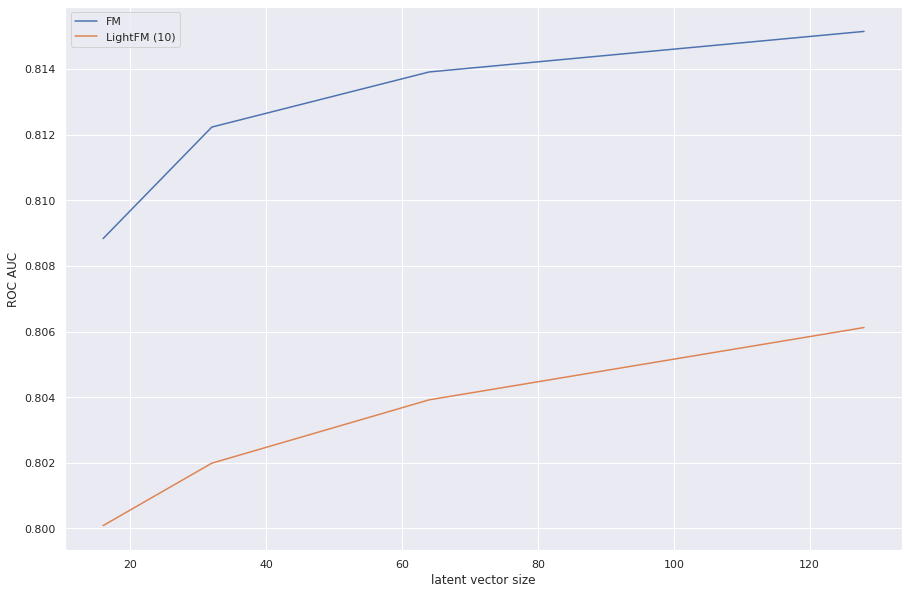

In [ ]:
no_components_range = np.logspace(4, 7, 4, base=2, dtype=np.int32)
no_components_range_high = np.logspace(7, 8, 2, base=2, dtype=np.int32)

plt.figure(figsize=(15,10))
plt.plot(no_components_range, roc_auc_mean, label='FM')
plt.plot(no_components_range, roc_auc_mean_10, label='LightFM (10)')
# plt.plot(no_components_range, roc_auc_mean_64, label='LightFM (64)')
# plt.plot(no_components_range, roc_auc_mean_10_noids, label='LightFM (10, no ids)')
# plt.plot(no_components_range, roc_auc_mean_nopca, label='LightFM (10, no pca)')
plt.xlabel('latent vector size')
plt.ylabel('ROC AUC')
plt.legend()